In [1]:
%reload_ext autoreload
%autoreload 2
from utils.bigram import *
from utils.helpers import *

# load val_data buy actively crawling the wiki pages in dataset/val_wiki.json
val_data, val_urls = load_val_data(num_pages=20)

# instantiate model
model = BigramLanguageModel(vocab_size)
model = nn.DataParallel(model)
model = model.to(device) # move model parameters to gpu if available

device: cuda
 0  https://www.wikipedia.org/wiki/Julie_%26_Julia
 1  https://www.wikipedia.org/wiki/Federal_Hall_National_Memorial
 2  https://www.wikipedia.org/wiki/Harry_Osborn
 3  https://www.wikipedia.org/wiki/Rafael_Gonzales
 4  https://www.wikipedia.org/wiki/Timeline_of_Channel_Television
 5  https://www.wikipedia.org/wiki/European_Golden_Shoe
 6  https://www.wikipedia.org/wiki/Epifany_Slavinetsky
 7  https://www.wikipedia.org/wiki/RTL_Passion
 8  https://www.wikipedia.org/wiki/Rangkiang
 9  https://www.wikipedia.org/wiki/David_Berg
10  https://www.wikipedia.org/wiki/Michael_Anderson_(director)
11  https://www.wikipedia.org/wiki/Vehicle_registration_plate
12  https://www.wikipedia.org/wiki/Hungama_TV
13  https://www.wikipedia.org/wiki/Christian_democracy
14  https://www.wikipedia.org/wiki/Flash_Forward
15  https://www.wikipedia.org/wiki/Christianity_in_Japan
16  https://www.wikipedia.org/wiki/Theurgy
17  https://www.wikipedia.org/wiki/Muridae
18  https://www.wikipedia.org/wiki/Fla

In [26]:
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, max_num_chars, True)
len(new_links), len(visited_urls)

num_chars_init:5722703  len(new_links):49850, len(visited_urls):247                                                                                                    
page_length: 10.1K, len(new_links):50089, len(visited_urls):248, num_chars:5.73M  https://www.wikipedia.org/wiki/Coffee_production_in_Hawaii                                                                      
page_length:  4.4K, len(new_links):50109, len(visited_urls):249, num_chars:5.74M  https://www.wikipedia.org/wiki/Wasted_Days_and_Wasted_Nights                                                                      
page_length: 25.8K, len(new_links):50246, len(visited_urls):250, num_chars:5.76M  https://www.wikipedia.org/wiki/Dominoes                                                                      
page_length: 11.3K, len(new_links):50360, len(visited_urls):251, num_chars:5.77M  https://www.wikipedia.org/wiki/C_band_(IEEE)                                                                      
page_length:  5.0K,

(54010, 275)

In [7]:
# Create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 
xb, yb = get_batch(train_data, batch_size)
logits, loss = model(xb, yb)

list_losses.append(loss.tolist())

losses = estimate_loss(model, train_data, eval_iters, -1, time.time())
list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape: {logits.shape}')
print(f'loss: {loss:.3f}')
print(r''.join(decode(generate(model, 
                               torch.zeros((1,1), device=device, dtype=torch.long),
                               max_new_tokens=100)[0].tolist())))

step   500: train_loss 1.9925, val_loss: 2.0902  (...Runtime: 1 min 55 sec)
step  1000: train_loss 1.5940, val_loss: 1.7809  (...Runtime: 3 min 51 sec)
step  1500: train_loss 1.4223, val_loss: 1.6252  (...Runtime: 5 min 46 sec)
step  2000: train_loss 1.3298, val_loss: 1.5661  (...Runtime: 7 min 42 sec)
step  2500: train_loss 1.2672, val_loss: 1.5316  (...Runtime: 9 min 37 sec)
step  3000: train_loss 1.2126, val_loss: 1.5158  (...Runtime: 11 min 33 sec)
step  3500: train_loss 1.1699, val_loss: 1.4993  (...Runtime: 13 min 28 sec)
step  4000: train_loss 1.1320, val_loss: 1.4833  (...Runtime: 15 min 23 sec)
step  4500: train_loss 1.0924, val_loss: 1.4837  (...Runtime: 17 min 19 sec)
step  5000: train_loss 1.0586, val_loss: 1.4879  (...Runtime: 19 min 14 sec)
step  5500: train_loss 1.0186, val_loss: 1.5070  (...Runtime: 21 min  9 sec)
step  6000: train_loss 0.9826, val_loss: 1.5276  (...Runtime: 23 min  3 sec)
step  6500: train_loss 0.9501, val_loss: 1.5430  (...Runtime: 24 min 58 sec)
step

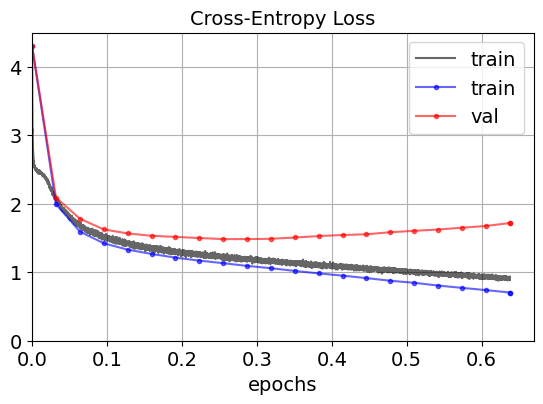

In [3]:
# train loop
start = time.time()
epoch = 0

for ib in range(1, max_iters + 1):
    # sample a batch of data
    xb, yb = get_batch(train_data, batch_size)
    
    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda'):
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients
    optimizer.step() # update parameters using the gradients
    
    # evaluate at fixed intervals
    epoch += batch_size / (len(train_data)-batch_size)
    if ib % eval_interval == 0 or ib == max_iters - 1:
        losses = estimate_loss(model, train_data, val_data, eval_iters, ib, start)
        list_epochs_eval.append(epoch)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])
    list_losses.append(loss.item())
    list_epochs.append(epoch)
    
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval)

# Generate text 
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(r''.join(decode(generate(model, 
                               torch.zeros((1,1), device=device, dtype=torch.long), 
                               max_new_tokens=400)[0].tolist()))) 

# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [14]:
train_data, val_data, num_chars, level = master_get_data(new_links, visited_urls, level, num_chars, max_num_chars)


------------------------------------------------------------------
started level: 1

shave(): No of visited urls removed: (0 urls)                                                                                                    
===> j:0  len(itrain_data): 30648                                    102 num_chars:3.77M  https://www.wikipedia.org/wiki/China_Girl_(song)                                                                                        

shave(): No of visited urls removed: (71 urls)                                                                                                    
===> j:1  len(itrain_data): 4851                                    ):203 num_chars:7.71M  https://www.wikipedia.org/wiki/342843_Davidbowie                                                                                                     

shave(): No of visited urls removed: (138 urls)                                                                                                    
===>

KeyboardInterrupt: 

## 2. Experiments
---

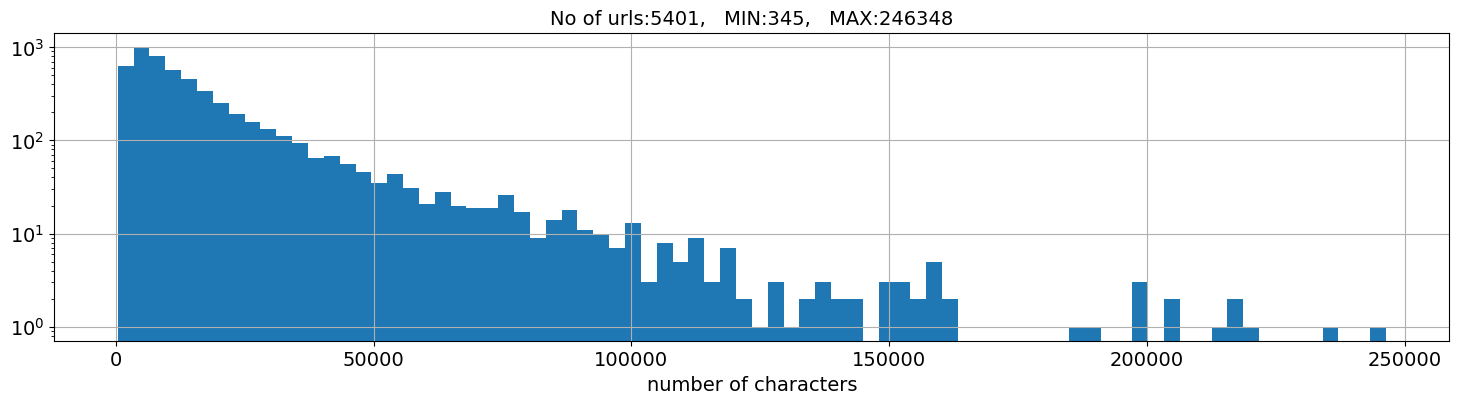

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


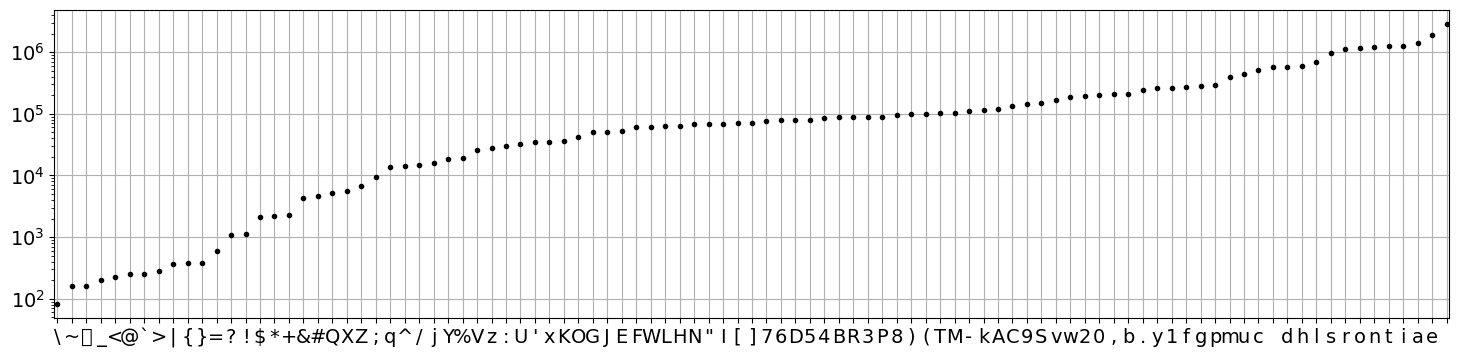

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)